In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from hydra import compose, initialize
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.manifold import MDS
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import get_dsa_run_list, load_session_data

In [3]:
with initialize(version_base="1.3", config_path="../../DSA_comparisons/conf"):
    cfg = compose(config_name="config")

In [4]:
data_class = os.path.basename(cfg.params.dsa_results_dir)
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, data_class)) if f.endswith('.mat')]

In [5]:
def floor(x, eps=1e-8):
    return np.intp(np.floor(x + eps))

# Compile Results

In [11]:
results_dir = os.path.join(cfg.params.dsa_results_dir, 'dsa_results')
normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

total_its = 0
for session in os.listdir(results_dir):
    session_results_dir = os.path.join(results_dir, session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"STRIDE_{cfg.params.stride}")
    for area in os.listdir(session_results_dir):
        total_its += len(os.listdir(os.path.join(session_results_dir, area)))

iterator = tqdm(total=total_its)

results = {}
for session in os.listdir(results_dir):
    dsa_run_list = get_dsa_run_list(session, cfg.params.dsa_results_dir, cfg.params.grid_search_results_dir, cfg.params.all_data_dir, T_pred=cfg.params.T_pred, stride=cfg.params.stride)
    session_results_dir = os.path.join(results_dir, session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"STRIDE_{cfg.params.stride}")
    results[session] = {}
    for area in os.listdir(session_results_dir):
        a = 1
        b = -1
        c = -2*len(dsa_run_list[area])
        n = int((-b+np.sqrt(b**2-4*a*c))/2*a)
        results[session][area] = np.zeros((n, n))

        dt = dsa_run_list[area][0]['dt']
        
        area_results_dir = os.path.join(session_results_dir, area)
        for f in os.listdir(area_results_dir):
            run_index = int(f.split('-')[1].split('.')[0])
            run_info = dsa_run_list[area][run_index]
            i = run_info['i']
            j = run_info['j']
            results[session][area][i, j] = pd.read_pickle(os.path.join(area_results_dir, f))['score']
            results[session][area][j, i] = results[session][area][i, j]
            iterator.update()
iterator.close()

  0%|          | 0/8373 [00:00<?, ?it/s]

In [122]:
# session = 'Mary-Anesthesia-20160818-02'
session = 'MrJones-Anesthesia-20160210-01'
dsa_run_list = get_dsa_run_list(session, cfg.params.dsa_results_dir, cfg.params.grid_search_results_dir, cfg.params.all_data_dir, T_pred=cfg.params.T_pred, stride=cfg.params.stride)
area = 'all'
a = 1
b = -1
c = -2*len(dsa_run_list[area])
n = int((-b+np.sqrt(b**2-4*a*c))/2*a)

In [123]:
variables = ['sessionInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=data_class, verbose=False)
session_info = session_vars['sessionInfo']

In [124]:
min_time = -15
max_time = 75

# time_vals = np.arange(n)*cfg.params.stride/60 - session_info['drugStart'][0]/60
min_t = np.min([run_info['window1_start'] for run_info in dsa_run_list[area]])
max_t = np.max([run_info['window2_start'] for run_info in dsa_run_list[area]])
time_vals = np.arange(min_t, max_t + stride/2, stride)/60 - session_info['drugStart'][0]/60
dissimilarity_mat = deepcopy(results[session][area])
# ind_offset = np.argmax((time_vals >= min_time) & (time_vals <= max_time))
ind_offset = 0
dissimilarity_mat = dissimilarity_mat[(time_vals >= min_time) & (time_vals <= max_time)]
dissimilarity_mat = dissimilarity_mat[:, (time_vals >= min_time) & (time_vals <= max_time)]
time_vals = time_vals[(time_vals >= min_time) & (time_vals <= max_time)]
log_dissimilarity_mat = deepcopy(dissimilarity_mat)
log_dissimilarity_mat[dissimilarity_mat > 0] = np.log(dissimilarity_mat[dissimilarity_mat > 0])

min_val = log_dissimilarity_mat[dissimilarity_mat > 0].min()
max_val = log_dissimilarity_mat[dissimilarity_mat > 0].max()

log_dissimilarity_mat[dissimilarity_mat == 0] = min_val

In [125]:
def convert_to_ind(t, stride):
    # print(t)
    # return int(np.round(t/stride))
    return np.intp(np.round((t - time_vals[0])*60/stride))

stride = cfg.params.stride

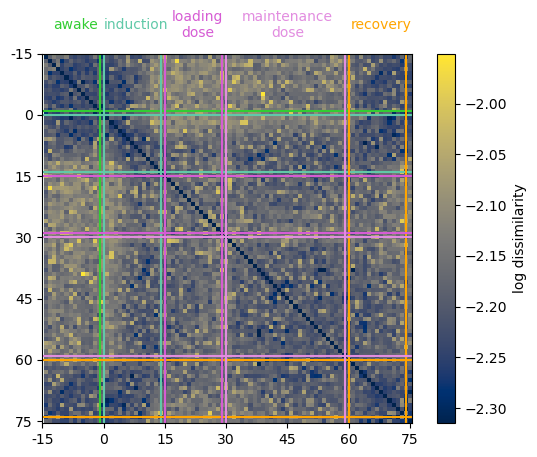

In [128]:

norm = Normalize(vmin=min_val, vmax=max_val)

plt.imshow(log_dissimilarity_mat, norm=norm, cmap='cividis')
plt.colorbar(label='log dissimilarity')

# xticks = plt.xticks()[0]
# xlim = plt.xlim()
# xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[-1])]
# xticklabels = [time_vals[int(tick)] for tick in xticks]

xticklabels = [-15, 0, 15, 30, 45, 60, 75]
xticks = [convert_to_ind(tl, stride) - ind_offset for tl in xticklabels]

plt.xticks(xticks, xticklabels)
plt.yticks(xticks, xticklabels)

vpos = -22.5
for section, times in section_info:
    plt.axhline(convert_to_ind(times[0], stride) - ind_offset, c=section_colors[section])
    plt.axhline(convert_to_ind(times[1], stride) - ind_offset - 1, c=section_colors[section])
    plt.axvline(convert_to_ind(times[0], stride) - ind_offset, c=section_colors[section])
    plt.axvline(convert_to_ind(times[1], stride) - ind_offset-1, c=section_colors[section])
    
    plt.text(convert_to_ind(np.mean(times), stride) - ind_offset, convert_to_ind(vpos, stride), '\n'.join(section.split(' ')), ha='center', va='center', c=section_colors[section])

plt.show()

In [129]:
dissim_mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto').fit_transform(log_dissimilarity_mat)

In [130]:
colors = []
for t in time_vals:
    for section, times in section_info:
        if t < times[1] and t >= times[0]:
            colors.append(section_colors[section])
            break

In [134]:
section_colors

{'awake': 'limegreen',
 'unconscious': 'plum',
 'recovery': 'orange',
 'loading dose': '#D65CD4',
 'maintenance dose': '#E28DE0',
 'early recovery': 'chocolate',
 'late recovery': '#FFBF47',
 'induction': '#61C9A8'}

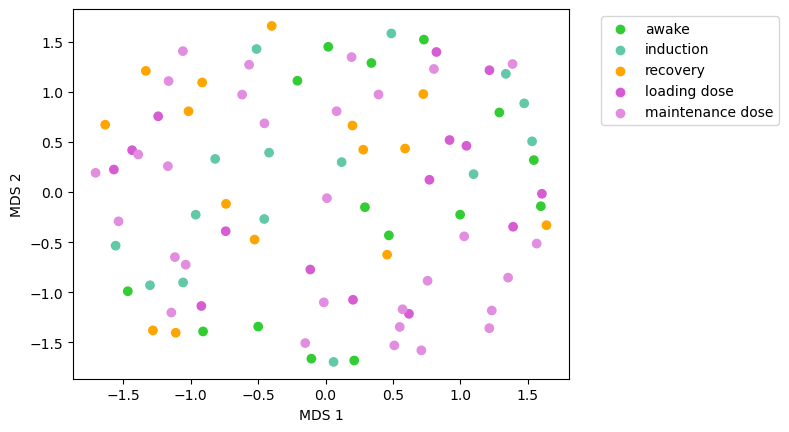

In [141]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(dissim_mds[:, 0], dissim_mds[:, 1], c=colors)
# ax.scatter(dissim_mds[:, 0], dissim_mds[:, 1], dissim_mds[:, 2], c=colors)

for section, times in section_info:
    plt.scatter([], [], c=section_colors[section], label=section)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.show()